# Traffic Signs classification using PyTorch and the GTSRB dataset
Road signs classification is one of the most important task performed by an autonomous car. In this project we use PyTorch library and the German Traffic Sign Recognition Benchmark dataset in order to train a Convolutional Neural Network to recognize such signs.

In [108]:
%%javascript
var rate = 0;
// apply setting to  all current CodeMirror instances
IPython.notebook.get_cells().map(
    function(c) {  return c.code_mirror.options.cursorBlinkRate=rate;  }
);

// make sure new CodeMirror instance also use this setting
CodeMirror.defaults.cursorBlinkRate=rate;

<IPython.core.display.Javascript object>

In [122]:
import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid
import numpy as np

## 1 - Loading the dataset

#### Data resizing
The dataset contains images of different sizes, the CNN architecture choosen in this project contains fully connected layers and hence doesn't allow inputs of different sizes. Each image in our dataset has a width/height ratio close to 1, hence we can resize each image to a fix size (conserving the ratio) and then center crop the image, hence loosing few informations.

#### Normalization of the images
We use the `Dataset` and `Dataloader` modules of PyTorch in order to load the dataset. 
We need to load the dataset a first time withtout normalization in order to compute the mean and the std of the data.

In [110]:
# we extend the Dataset class in order to create our own dataset
class RoadSignsDatasetRaw(Dataset):
    def __init__(self, datasets_path, csv_name, image_size):
        # read the csv file containing all the paths of the samples
        self.metadatas = pd.read_csv(datasets_path + '/' + csv_name)
        self.datasets_path = datasets_path
        
        # we sequentially resize and center crop the image (as described above)
        self.transform = torch.nn.Sequential(
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size)
        )
    
    def __len__(self):
        return len(self.metadatas.index)
    
    def __getitem__(self, idx):
        # the path of each image is in the "Path" column of the dataframe
        img_path = self.metadatas.loc[idx, "Path"]
        
        # we read each image as a tensor
        image = read_image(self.datasets_path + '/' + img_path).float()
        image = self.transform(image)
        
        # label of each feature is in the "ClassId" column
        label = self.metadatas.loc[idx, "ClassId"]
        return image, label

In [128]:
# load raw data
train_data_raw = RoadSignsDatasetRaw("datasets", "Train.csv", 32)
train_dataloader_raw = DataLoader(train_data_raw, batch_size=64, shuffle=True)

# get first batch of the data
features, _ = next(iter(train_dataloader_raw))

# compute mean and standard derivation
mean, std = features.mean([0, 2, 3]), features.std([0, 2, 3])
print("Mean, and std for [R, G, B] channels:")
print(f"mean = {mean}, std = {std}")

mean = (mean[0], mean[1], mean[2])
std = (std[0], std[1], std[2])

nb_classes = 43

Mean, and std for [R, G, B] channels:
mean = tensor([85.8447, 80.3387, 82.9710]), std = tensor([67.1220, 65.7194, 67.3007])


Now that we computed the mean and standard derivation for each of the RGB channels, we can normalize the data with the built-in `transforms.Normalize` function

In [112]:
# we extend the Dataset class in order to create our own dataset
class RoadSignsDataset(Dataset):
    def __init__(self, datasets_path, csv_name, image_size):
        # read the csv file containing all the paths of the samples
        self.metadatas = pd.read_csv(datasets_path + '/' + csv_name)
        self.datasets_path = datasets_path
        
        # we sequentially resizen, center crop the image and normalize (as described above)
        self.transform = torch.nn.Sequential(
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size),
            transforms.Normalize(mean, std)
        )
    
    def __len__(self):
        return len(self.metadatas.index)
    
    def __getitem__(self, idx):
        img_path = self.metadatas.loc[idx, "Path"]
        image = read_image(self.datasets_path + '/' + img_path).float()
        image = self.transform(image)
        label = self.metadatas.loc[idx, "ClassId"]
        return image, label

Now we load the normalized dataset for both training and testing. We create mini-batches of size 64 with `DataLoader` in order to reduce the converging time and to reduce overfitting.

In [143]:
from torch.utils.data import DataLoader
from torchvision import transforms

test_data = RoadSignsDataset("datasets", "Test.csv", 64)
train_data = RoadSignsDataset("datasets", "Train.csv", 64)

batch_size = 64

test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

We instantiate the helper function `imshow` to facilitate image displaying. (we need to un-normalize the image before plotting it)

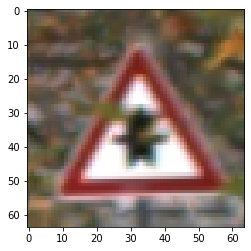

In [144]:
import matplotlib.pyplot as plt

# Get a random batch from the training data
batch_features, batch_labels = next(iter(train_dataloader))
img = batch_features[0].squeeze()
label = batch_labels[0]

# Convert mean and std tuples to tensors
meanTensor, stdTensor = torch.FloatTensor(mean), torch.FloatTensor(std)

"""
    floatTensor: tensor of the image to show
    normalized: if the tensor is normalized or not
"""
def imshow(floatTensor, normalized = True):
    if normalized == True:
        for k in range(3):
            for i in range(floatTensor.size(1)):
                for j in range(floatTensor.size(2)):
                    floatTensor[k, i, j] = floatTensor[k, i, j] * stdTensor[k] + meanTensor[k]
    plt.imshow(floatTensor.int().permute(1, 2, 0))
    plt.show()

#print(img)
imshow(img)

## 2 - Building & training the CNN

#### Building the CNN
In this project we use an architecture similar to the LeNet architecture. We stack 2 convolutions layers with pooling layers between them. Notice we set the padding to 2 in order to keep the informations at the corners and edges.
Then we use 3 fully connected layers for classification.

In [150]:
from torchsummary import summary

class convGTSRB(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 5, 5, stride = 1, padding = 2)
        self.conv2 = nn.Conv2d(5, 20, 5, stride = 1, padding = 2)
        
        self.fc1 = nn.Linear(16 * 16 * 20, 120)
        self.fc2 = nn.Linear(120, 80)
        self.fc3 = nn.Linear(80, nb_classes)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        
        x = x.view(-1, 16 * 16 * 20)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim = 1)
        return x
    
model = convGTSRB()

summary(model, (3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 5, 64, 64]           380
├─Conv2d: 1-2                            [-1, 20, 32, 32]          2,520
├─Linear: 1-3                            [-1, 120]                 614,520
├─Linear: 1-4                            [-1, 80]                  9,680
├─Linear: 1-5                            [-1, 43]                  3,483
Total params: 630,583
Trainable params: 630,583
Non-trainable params: 0
Total mult-adds (M): 4.72
Input size (MB): 0.05
Forward/backward pass size (MB): 0.31
Params size (MB): 2.41
Estimated Total Size (MB): 2.77


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 5, 64, 64]           380
├─Conv2d: 1-2                            [-1, 20, 32, 32]          2,520
├─Linear: 1-3                            [-1, 120]                 614,520
├─Linear: 1-4                            [-1, 80]                  9,680
├─Linear: 1-5                            [-1, 43]                  3,483
Total params: 630,583
Trainable params: 630,583
Non-trainable params: 0
Total mult-adds (M): 4.72
Input size (MB): 0.05
Forward/backward pass size (MB): 0.31
Params size (MB): 2.41
Estimated Total Size (MB): 2.77

In [151]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
epochs = 3 # number of epochs

#### Optimization of our model
We iterate over the epochs and for each batch we compute the gradient. Then we compute the loss

In [152]:
sum_loss = 0
n = 0

for epoch in range(epochs):
    print(f"------ epoch n°{epoch + 1} ------")
    for b, data in enumerate(train_dataloader):
        inputs, labels = data
        
        # Zero the gradient
        optimizer.zero_grad()
        
        # Pass the inputs to the model
        outputs = model(inputs)
        
        # Compute the loss 
        loss = criterion(outputs, labels)
        
        # Get the loss gradient
        loss.backward()
        
        # Optimize the model
        optimizer.step()
        
        # Compute the loss over the batches
        sum_loss += loss.item()
        n += 1
        if b % 50 == 49:
            print(f"epoch n°{epoch + 1}, batch n°{b + 1} loss is {sum_loss / n}")
            n = 0
            sum_loss = 0

------ epoch n°1 ------
epoch n°1, batch n°50 loss is 3.4028233337402343
epoch n°1, batch n°100 loss is 2.343708257675171
epoch n°1, batch n°150 loss is 1.7483541321754457
epoch n°1, batch n°200 loss is 1.3208242559432983
epoch n°1, batch n°250 loss is 1.0425269889831543
epoch n°1, batch n°300 loss is 0.7882348215579986
epoch n°1, batch n°350 loss is 0.6341718912124634
epoch n°1, batch n°400 loss is 0.5070845699310302
epoch n°1, batch n°450 loss is 0.44795484364032745
epoch n°1, batch n°500 loss is 0.3560643774271011
epoch n°1, batch n°550 loss is 0.3326083320379257
epoch n°1, batch n°600 loss is 0.2931748107075691
------ epoch n°2 ------
epoch n°2, batch n°50 loss is 0.20662843258607955
epoch n°2, batch n°100 loss is 0.2227526691555977
epoch n°2, batch n°150 loss is 0.20943645820021628
epoch n°2, batch n°200 loss is 0.1764552354812622
epoch n°2, batch n°250 loss is 0.16042022995650768
epoch n°2, batch n°300 loss is 0.2019975572824478
epoch n°2, batch n°350 loss is 0.13678376287221908


We can see a quick visualization below of how our model perform.

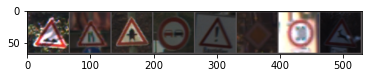

Actual:
[tensor(22), tensor(24), tensor(11), tensor(9), tensor(18), tensor(12), tensor(1), tensor(31)]
Predicted:
[tensor(22), tensor(24), tensor(11), tensor(9), tensor(18), tensor(12), tensor(1), tensor(31)]


In [153]:
images, labels = next(iter(test_dataloader))

n = 8
imshow(make_grid(images[:n]))

print("Actual:")
print([labels[i] for i in range(n)])

with torch.no_grad():
    outputs = model(images)

_, predicted = torch.max(outputs, 1)

print("Predicted:")
print([predicted[i] for i in range(n)])

## 3 - Model evaluation
Below we compute the total accuracy of our model and the precision & recall for each of the classes.

In [154]:
n = 0
correct = 0
b = 0

class_names = ["20km", "30km", "50km", "60km", "70km", "80km", "end_80km", "100km", "120km", "no_overtake_cars",
              "no_overtake_trucks", "crossroad", "priority_road", "yield_to_others", "stop", "forbidden", "trucks_forbidden",
              "road_forbidden", "danger", "left_turn", "right_turn", "left_right_turn", "speed_bump",
              "icy_road", "road_reduction", "workers", "traffic_light", "crosswalk", "children", "bycicles",
              "ice", "wildlife", "end_forbidden", "turn_right", "turn_left", "go_straight", "go_straight_or_right",
              "go_straight_or_left", "go_slightly_right", "go_slightly_left", "roundabout", "end_no_overtake_cars",
              "end_no_overtake_trucks"]

# Create a performance table to store number of correctly and incorrectly classified samples
# for each class
# column 0 is the true positive
# column 1 is the false negative
# column 2 is the false positive
performance = np.zeros([nb_classes, 3])


with torch.no_grad():
    for test_batch in test_dataloader:
        b += 1
        batch_correct = 0
        images, labels = test_batch

        # pass each batch to the trained model
        outputs = model(images)
        
        # get the predicted class as an int
        _, predictions = torch.max(outputs, 1)
        
        n += labels.size(0)
        batch_n = labels.size(0)
        for i in range(labels.size(0)):
            if predictions[i] == labels[i]:
                correct += 1
                batch_correct += 1
                performance[predictions[i], 0] += 1
            else:
                performance[labels[i], 1] += 1
                performance[predictions[i], 2] += 1

        if b % 25 == 0:
            print(f"batch n°{b} has {batch_correct} correct out of {batch_n}")

print("")

# Compute and display the recall & precision for each class
for i in range(nb_classes):
    recall = performance[i, 0] / (performance[i, 0] + performance[i, 1])
    precision = performance[i, 0] / (performance[i, 0] + performance[i, 2])
    print(f"{class_names[i]:<25}      recall: {recall:.2f}, precision: {precision:.2f}")
    
print("")
print(f"accuracy of the model is : {correct / n}")

batch n°25 has 55 correct out of 64
batch n°50 has 58 correct out of 64
batch n°75 has 52 correct out of 64
batch n°100 has 59 correct out of 64
batch n°125 has 60 correct out of 64
batch n°150 has 61 correct out of 64
batch n°175 has 57 correct out of 64

20km                           recall: 0.50, precision: 0.88
30km                           recall: 0.92, precision: 0.91
50km                           recall: 0.94, precision: 0.91
60km                           recall: 0.85, precision: 0.90
70km                           recall: 0.95, precision: 0.92
80km                           recall: 0.86, precision: 0.86
end_80km                       recall: 0.73, precision: 0.99
100km                          recall: 0.67, precision: 0.98
120km                          recall: 0.96, precision: 0.71
no_overtake_cars               recall: 0.99, precision: 0.93
no_overtake_trucks             recall: 0.97, precision: 0.99
crossroad                      recall: 0.95, precision: 0.89
priority_ro

Finally we save our model in a separate file.

In [17]:
path = "models/884acc"
torch.save(model.state_dict(), path)